### Initialise

In [103]:
## Import necessary packages
import matplotlib.pyplot as plt; 
import pandas as pd; 
import numpy as np; 
from datetime import datetime; 

from sklearn.model_selection import train_test_split;
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import python.data as datameta

In [104]:
def rd(a): return round(a,4)
def mse(a,b): return rd(mean_squared_error(a,b)); 
def rmse(a,b): return rd(mse(a,b)**0.5); 
def mae(a,b): return rd(mean_absolute_error(a,b)); 
def r2(a,b): return rd(r2_score(a,b)**0.5); 
def isClose(base, known, tol=0.001): return np.abs((base - known) / base) <= tol

def row(name,ytest, yhat, accuracy):
    accuracies = list(map(
        lambda x: str(round(x*100, 2))+"%"
        ,accuracy)) 
    return [
        name, 
        r2(ytest, yhat),mae(ytest, yhat),mse(ytest, yhat), 
        accuracies[0], accuracies[1], accuracies[2]
    ]

### Preprocess Data

In [105]:
data = datameta.processData('data/clean_data.csv'); 
data.head()

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Sugar feed rate(Fs:L/h)',
       'Acid flow rate(Fa:L/h)', 'Base flow rate(Fb:L/h)',
       'Air head pressure(pressure:bar)', 'Substrate concentration(S:g/L)',
       'Penicillin concentration(P:g/L)', 'Vessel Volume(V:L)', 'pH(pH:pH)',
       'Temperature(T:K)', 'PAA flow(Fpaa:PAA flow (L/h))',
       'Oil flow(Foil:L/hr)', 'Ammonia shots(NH3_shots:kgs)', 'Water Flow'],
      dtype='object') 

 (113935, 15)


,Time (h),Aeration rate(Fg:L/h),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Air head pressure(pressure:bar),Substrate concentration(S:g/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),pH(pH:pH),Temperature(T:K),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Ammonia shots(NH3_shots:kgs),Water Flow
0,0.000000,0.181818,0.040541,0.000000,0.133858,0.0,0.008306,1.791808e-27,0.049276,0.767126,0.258427,0.333333,0.0,0.0,0.004470
1,0.000690,0.181818,0.040541,0.000000,0.227649,0.0,0.008715,2.763729e-05,0.049480,0.800686,0.249064,0.333333,0.0,0.0,0.008252
2,0.001380,0.181818,0.040541,0.000000,0.241342,0.0,0.009107,2.761905e-05,0.049685,0.836653,0.243446,0.333333,0.0,0.0,0.004363
3,0.002070,0.181818,0.040541,0.000000,0.168071,0.0,0.009492,2.760247e-05,0.049787,0.860582,0.237828,0.333333,0.0,0.0,0.001972
4,0.002761,0.181818,0.040541,0.039866,0.084036,0.0,0.009864,2.758782e-05,0.049838,0.865835,0.234082,0.333333,0.0,0.0,0.000502


In [106]:
# Split into x and y
xkeys = [
    "Time (h)", "Aeration rate(Fg:L/h)", "Sugar feed rate(Fs:L/h)","Acid flow rate(Fa:L/h)",
    "Base flow rate(Fb:L/h)","Water Flow","Substrate concentration(S:g/L)","PAA flow(Fpaa:PAA flow (L/h))",
    "Oil flow(Foil:L/hr)", "Ammonia shots(NH3_shots:kgs)",
    # Converted variables
    "Air head pressure(pressure:bar)", "Temperature(T:K)", "pH(pH:pH)", "Vessel Volume(V:L)"
]
(x,y) = datameta.xy_split(data,xkeys)
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.11)
ytest = ytest.to_numpy().flatten(); 

x:  14  keys in  14 cols
y:  1  keys in  1 cols


In [107]:
model = DecisionTreeRegressor()
model.fit(xtrain,ytrain)

def pct(val): return round(val*100,2); 
def pcts(val): return str(round(val*100,2))+"%"; 

print(
    f"Train: {pcts(model.score(xtrain,ytrain))}\n",
    f"Test: {pcts(model.score(xtest,ytest))}"
)

Train: 100.0%
 Test: 99.42%


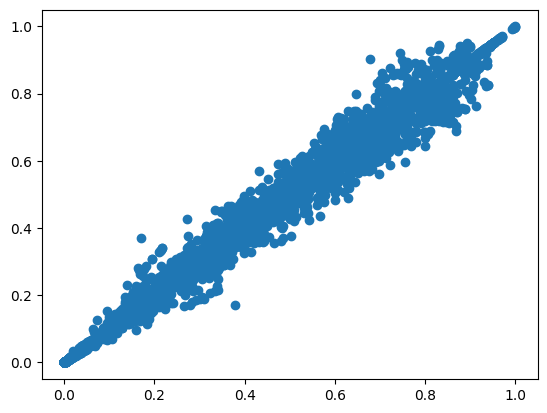

In [108]:
prediction=model.predict(xtest)
plt.scatter(ytest,prediction)

In [109]:
parameters={
    "splitter":["best","random"],
    "max_depth" : [1,3,5,7,9,11,12],
    "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
    "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    "max_features":[1.0,"log2","sqrt",None],
    "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] 
}

In [110]:
from sklearn.model_selection import GridSearchCV; 

tuning_model=GridSearchCV(model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3)

tuning_model.fit(x, y)

In [115]:
import json

print("BEST: ",tuning_model.best_params_, tuning_model.best_score_)
results = pd.DataFrame(tuning_model.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
configs = results[:5]["params"].to_numpy().tolist()
configs = json.dumps(configs)
print(configs)

file = open("data/dtr_cfgs.json", "w+")
content = str(configs)
file.write(content)
file.close()

BEST:  {'max_depth': 5, 'max_features': 1.0, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'} -0.007800699735532828
[{"max_depth": 9, "max_features": 1.0, "max_leaf_nodes": null, "min_samples_leaf": 2, "min_weight_fraction_leaf": 0.1, "splitter": "best"}, {"max_depth": 11, "max_features": null, "max_leaf_nodes": 30, "min_samples_leaf": 6, "min_weight_fraction_leaf": 0.1, "splitter": "best"}, {"max_depth": 11, "max_features": 1.0, "max_leaf_nodes": 90, "min_samples_leaf": 9, "min_weight_fraction_leaf": 0.1, "splitter": "best"}, {"max_depth": 7, "max_features": null, "max_leaf_nodes": 80, "min_samples_leaf": 1, "min_weight_fraction_leaf": 0.1, "splitter": "best"}, {"max_depth": 12, "max_features": null, "max_leaf_nodes": 60, "min_samples_leaf": 4, "min_weight_fraction_leaf": 0.1, "splitter": "best"}]


In [118]:
file = open("data/dtr_cfgs.json", "r")
content = file.read()
file.close()
configs = json.loads(content)

In [128]:
import json
table = [0,0,0,0,0, 0]

for index,config in enumerate(configs):
    print(f"Running: {config}")
    tmodel = DecisionTreeRegressor(**config); 
    tmodel.fit(xtrain,ytrain); 

    yhat = tmodel.predict(xtest)

    accuracies = list(map(
        lambda x: np.sum(isClose(yhat, ytest, x))/len(ytest)
    ,[0.001, 0.01, 0.1])) 
    print(f"Accuracies: {accuracies}")
    table[index] = row(json.dumps(config), ytest, model.predict(xtest), accuracies)

print(f"Running: NULL")
tmodel = DecisionTreeRegressor(); 
tmodel.fit(xtrain,ytrain); 
yhat = tmodel.predict(xtest)
accuracies = list(map(
        lambda x: np.sum(isClose(yhat, ytest, x))/len(ytest)
    ,[0.001, 0.01, 0.1])) 
print(f"Accuracies: {accuracies}")
table[len(table)-1] = row("None", ytest, model.predict(xtest), accuracies)

table = pd.DataFrame(table, columns=["","R2","MAE", "MSE","Acc@0.1%", "Acc@1%", "Acc@10%"]); 
table

Running: {'max_depth': 9, 'max_features': 1.0, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
Accuracies: [0.0047873613659937765, 0.044442671347642224, 0.3876166919332961]
Running: {'max_depth': 11, 'max_features': None, 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
Accuracies: [0.0047873613659937765, 0.044442671347642224, 0.3876166919332961]
Running: {'max_depth': 11, 'max_features': 1.0, 'max_leaf_nodes': 90, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
Accuracies: [0.0047873613659937765, 0.044442671347642224, 0.3876166919332961]
Running: {'max_depth': 7, 'max_features': None, 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
Accuracies: [0.0047873613659937765, 0.044442671347642224, 0.3876166919332961]
Running: {'max_depth': 12, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 4, 'min_wei

,,R2,MAE,MSE,Acc@0.1%,Acc@1%,Acc@10%
0,"{""max_depth"": 9, ""max_features"": 1.0, ""max_lea...",0.9971,0.0077,0.0004,0.48%,4.44%,38.76%
1,"{""max_depth"": 11, ""max_features"": null, ""max_l...",0.9971,0.0077,0.0004,0.48%,4.44%,38.76%
2,"{""max_depth"": 11, ""max_features"": 1.0, ""max_le...",0.9971,0.0077,0.0004,0.48%,4.44%,38.76%
3,"{""max_depth"": 7, ""max_features"": null, ""max_le...",0.9971,0.0077,0.0004,0.48%,4.44%,38.76%
4,"{""max_depth"": 12, ""max_features"": null, ""max_l...",0.9971,0.0077,0.0004,0.48%,4.44%,38.76%
5,None,0.9971,0.0077,0.0004,19.27%,70.13%,92.29%
